## Model Training

Transformers will be used to train the Machine Learning Model. It is possible due to complexity that this notebook will be trained in Google Colab and later download to this repo.



In [1]:
import pandas as pd
import numpy as np
import os
from datasets import load_dataset, Features, ClassLabel, Value
dir_root = os.getcwd()
dir_root

/home/falconiel/anaconda3/envs/mlenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/home/falconiel/CodePrograms/clasificaion_robos_fge'

We will be using Hugging Face load rutines in order to load data and processed it. There is somehow some things that I feel like a bit lost, because in some of the examples that I have checked on huggnif faces they are not using one hot encoding. In the end we have to build a multiclass clasification and the doubt I have is if I should use the one hot variables or should only use the hagging face. If this does not work I will have to test how the Youtube video stored the tensors in numpy format, hoping that all tokenization will be able to be run

In [2]:
dataset_df = pd.read_csv(os.path.join(dir_root, 'data/interim/trainset.csv'), converters={'NDD':str})
dataset_df.sample(5)

,index,ndd,relato,cantidadPalabras,tipoDelitoPj,target,labelsRoboADomicilio,labelsRoboAPersonas,labelsRoboAUnidadesEconomicas,"labelsRoboDeBienes,AccesoriosYAutopartesDeVehiculos",labelsRoboDeCarros,labelsRoboDeMotos,labels
241867,15871,20101816040036,señora fiscal adjunto al presente el parte pol...,177,ROBO,3,0,0,0,0,0,1,ROBO DE MOTOS
149511,339870,170101818011579,hace conocer del hecho el servicio de segurida...,38,ROBO,6,0,1,0,0,0,0,ROBO A PERSONAS
4416,151629,90101819063165,es el caso señor fiscal que el día 15 de junio...,239,ROBO,2,0,0,0,0,1,0,ROBO DE CARROS
8737,353741,170101819020015,es el caso sra fiscal que el día viernes 25 de...,81,ROBO,6,0,1,0,0,0,0,ROBO A PERSONAS
205602,425757,240101821050026,es el caso señor fiscal que el día de ayer 5 d...,196,ROBO,5,1,0,0,0,0,0,ROBO A DOMICILIO


In [3]:
labels_set = set(dataset_df.labels.to_list())

In [4]:
traincsv = os.path.join(dir_root, 'data/interim/trainsethugf.csv')
testcsv = os.path.join(dir_root, 'data/interim/testsethugf.csv')
validcsv = os.path.join(dir_root, 'data/interim/validsethugf.csv')
# class_names = ["RoboADomicilio", "RoboAPersonas", "RoboAUnidadesEconomicas", "RoboDeBienesAccesoriosYAutoPartes", "RoboDeCarros", "RoboDeMotos"]
class_names = list(labels_set)
robo_features = Features({'relato': Value('string'), 'labels': ClassLabel(names=class_names)})
dataset = load_dataset('csv', 
data_files={'train': traincsv, 'test': testcsv, 'validation':validcsv}, features=robo_features)

Using custom data configuration default-d21d64232480290a


Extracting data files: 100%|██████████| 3/3 [00:00<00:00, 1343.04it/s]


Dataset csv downloaded and prepared to /home/falconiel/.cache/huggingface/datasets/csv/default-d21d64232480290a/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 515.29it/s]


In [5]:
dataset['train'][-5]

{'relato': 'es el caso señor fiscal que el día de hoy 08 de junio del 2019 aproximadamente a las 05h40 en circunstancias que me transportaba en el bus de la línea ctp 4 rumbo al mercado de transferencia de víveres y al llegar a la altura de la planta procesadora de gas 2 sujetos desconocidos que viajaban en el mismo bus sacaron arma de fuego y empezaron bajo amenazas a robar las pertenencias de todos los pasajeros a mí se me llevaron mi teléfono celular iphone 6 activado con la línea 0958963277 de la operadora movistar por lo expuesto señor fiscal denuncio lo sucedido para que se realicen las investigaciones respectivas recibiré notificaciones en el correo electrónico joann24e gmail com',
 'labels': 5}

In [6]:
seqlen = dataset_df.relato.apply(lambda x: len(x.split()))

Let us create an Histogram of the word count in Crime report

/home/falconiel/anaconda3/envs/mlenv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='relato', ylabel='Density'>

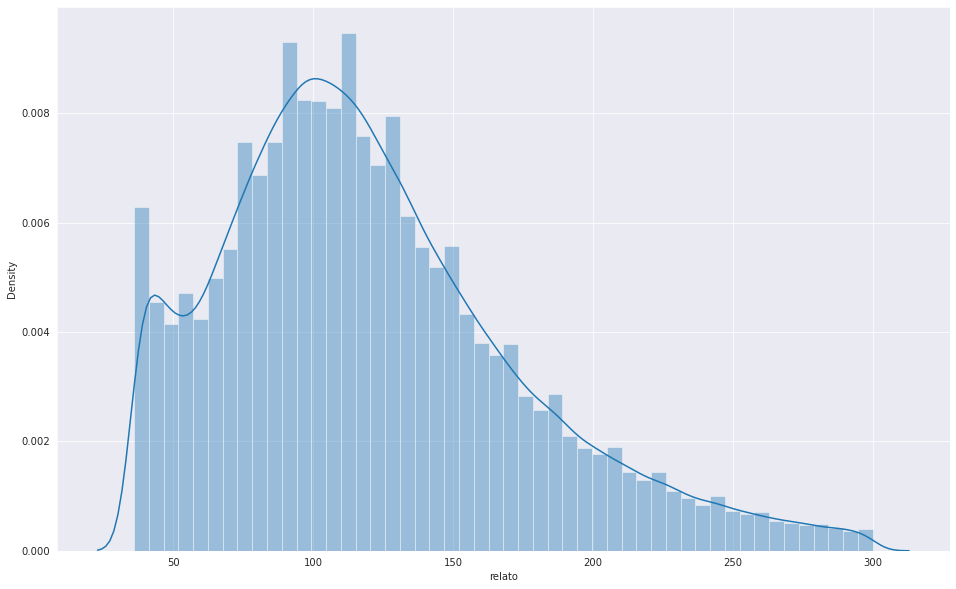

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.figure(figsize=(16,10))
sns.distplot(seqlen)

In a example solved in https://www.youtube.com/watch?v=GYDFBfx8Ts8&t=498s, the length of the sequence was set to the maximum span of the distplot. This would imply to use a length sequence of 300. I think padding and trucate are used in consequence with this size so that all tensors in would have the same length. I think that if we chouse $SEQ_LEN<200$, those reports with values below 200 will be truncated (This is something that I need to understand when writing the paper). Now by choosing to use the maximum length, which appears to be somehow 300, there should be no truncation but padding to some of the records. Let us consider what is the maximum length of the Crime report

In [8]:
seqlen.max()

300

In [9]:
dataset_df.cantidadPalabras.max()

300

We have already separated the original dataset in Train and Test. Because of that, we would split this train dataset in train and validation. Test set will be used at the end in order to proof the concept

In [10]:
dataset_df.columns

Index(['index', 'ndd', 'relato', 'cantidadPalabras', 'tipoDelitoPj', 'target',
       'labelsRoboADomicilio', 'labelsRoboAPersonas',
       'labelsRoboAUnidadesEconomicas',
       'labelsRoboDeBienes,AccesoriosYAutopartesDeVehiculos',
       'labelsRoboDeCarros', 'labelsRoboDeMotos', 'labels'],
      dtype='object')

In [11]:
# X_set = dataset_df.RELATO.to_list()
# Y_set = dataset_df[['LABELS_ROBO A DOMICILIO', 
# 'LABELS_ROBO A PERSONAS',
# 'LABELS_ROBO A UNIDADES ECONOMICAS',
# 'LABELS_ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS',
# 'LABELS_ROBO DE CARROS',
# 'LABELS_ROBO DE MOTOS']].to_numpy()

In [12]:
# X_set.iloc[0,:], Y_set.iloc[0,:]

In [13]:
# dataset_df.head()

In [14]:
# Y_set[:5,:]

In [15]:
# X_set[:5]

In [16]:
# len(X_set), Y_set.shape

Since the classification is of type Multicategorical, it is clear that:

$\mathbf{y} \in\mathcal{R}^6   $ corresponds to the labels of our set. The structure of $ \mathbf{X} $ will depend on the tokenization process. 

Moreover there are possible two ways to test.

1. The provided guide at https://huggingface.co/transformers/v3.2.0/custom_datasets.html, does not use attention masks. We could test first this approach.
2. We could follow the lead of https://www.youtube.com/watch?v=GYDFBfx8Ts8&t=498s, and provide both input_ids and masks_ids
3. We should compare how things go provided the classical approach by using count of words (wordvec, bag of words and others) And compare results.
4. There is something that is not being considered in this approach and it is unbalanced data. We should think about a way of balancing data

<AxesSubplot:>

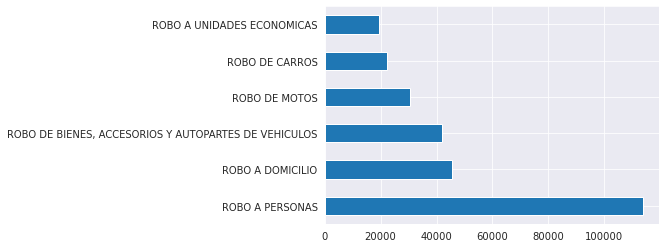

In [17]:
dataset_df.labels.value_counts().plot.barh()

I think and interesting way of solving could by making an ensemble by distributing different samples in each **weak** learner. Eventhough it is not a weak learner because they are actually transformer-convnet based learners. 

Also, it must be noticed that we are going through fine tuning a pre-trained bert model. What would happen if we train it from scratch? would it be better?

In [18]:
from transformers import DistilBertTokenizer, AutoTokenizer, DistilBertTokenizerFast
# model_name = 'xlm-roberta-large'
# model_name = 'bert-base-cased'
# model_name = 'bert-base-multilingual-uncased-sentiment'
model_name = 'distilbert-base-multilingual-cased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

Testing tokenizer with any kind of content

In [19]:
tokenizer('el CASTELLANO es una LENGUA muerta')

{'input_ids': [101, 10125, 92923, 29833, 82834, 41275, 11403, 10196, 10153, 84977, 34065, 12022, 10738, 12361, 43861, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
def tokenizer_func(examples):
  return tokenizer(examples["relato"],
                   max_length=seqlen.max(),
                   padding = "max_length",
                   truncation=True)

tokenized_dataset = dataset.map(tokenizer_func, batched=True)

Parameter 'function'=<function tokenizer_func at 0x7f7e60616170> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|██████████| 69/69 [00:13<00:00,  4.99ba/s]


In [21]:
len(tokenized_dataset['validation'][-1]['input_ids']), tokenized_dataset['validation'][-1]['labels']

(300, 5)

In [22]:
tokenized_dataset['train'][0]

{'relato': 'es el caso señor fiscal que el día 22 de octubre del 2014 a las 20h40 aproximadamente en circunstancias en que deje estacionado mi camioneta de placas gmd0996 color blanco marca chevrolet de mi propiedad en la dirección antes mencionada al momento de ir por ella me encuentro con la novedad que no estaba se la habían robado en el interior de la camioneta ahí una arma de fuego revolver calibre 38 de fabricación nacional que pertenece a compañía armiled por lo expuesto señor fiscal solicito que se realicen las respectivas investigaciones es justicia',
 'labels': 3,
 'input_ids': [101,
  10196,
  10125,
  13101,
  47599,
  43645,
  10121,
  10125,
  14184,
  10306,
  10104,
  14082,
  10127,
  10194,
  169,
  10285,
  10197,
  10237,
  38109,
  21278,
  10110,
  109050,
  10110,
  10121,
  10104,
  10381,
  11504,
  57416,
  12132,
  88406,
  17670,
  10213,
  10104,
  93697,
  175,
  37527,
  10929,
  88657,
  11211,
  14136,
  34488,
  13534,
  10262,
  99959,
  12630,
  1010

In [23]:
import tensorflow as tf
tf.__version__

'2.8.1'

Following what is proposed in: https://huggingface.co/docs/transformers/tasks/sequence_classification

In [24]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [25]:
tokenized_dataset.keys()

dict_keys(['train', 'test', 'validation'])

In [26]:
tf_train_set = tokenized_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = tokenized_dataset["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

2022-07-07 12:59:06.772302: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [35]:
from transformers import TFAutoModelForSequenceClassification, TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=6)

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream ta

In [36]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 134734080 
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 135,329,286
Trainable params: 135,329,286
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.layers[0].trainable = False
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [41]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 134734080 
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 135,329,286
Trainable params: 595,206
Non-trainable params: 134,734,080
_________________________________________________________________


In [43]:
history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3)

Epoch 1/3
17084/17084 [==============================] - 42208s 2s/step - loss: 1.3342 - val_loss: 1.1227
Epoch 2/3
11616/17084 [===================>..........] - ETA: 3:03:24 - loss: 1.1066

In [42]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')